Nathan Deinlein <br>
Ryan Kinney <br>
Chris Roche <br>
Cameron Stewart <br>

# Machine Learning 1 - Lab 3 Clustering

## Section 1: Business Understanding 1

Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). How will you measure the effectiveness of a good algorithm? Why does your chosen validation method make sense for this specific dataset and the stakeholders needs?

...

## Section 2: Data Understanding 1

Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file. Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems?

...

### Sub-Section 1.1: Load in and Prepare Data

#### Load Libraries

In [33]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics as mt
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, roc_auc_score
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

#### Read in data

In [2]:
url = "https://raw.githubusercontent.com/nedeinlein/Machine_Learning_I/main/runs_clean.csv"
runs_df = pd.read_csv(url, index_col=False)
print('Data set shape:',runs_df.shape)
runs_df.head()

Data set shape: (79423, 29)


,Unnamed: 0,race_id,horse_no,horse_id,result,won,lengths_behind,horse_age,horse_country,horse_type,...,behind_sec2,behind_sec3,time1,time2,time3,finish_time,win_odds,place_odds,trainer_id,jockey_id
0,0,0,1,3917,10,0.0,8.00,3,AUS,Gelding,...,2.00,1.50,13.85,21.59,23.86,83.92,9.7,3.7,118,2
1,1,0,2,2157,8,0.0,5.75,3,NZ,Gelding,...,9.00,5.00,14.57,21.99,23.30,83.56,16.0,4.9,164,57
2,2,0,3,858,7,0.0,4.75,3,NZ,Gelding,...,1.00,0.75,13.69,21.59,23.90,83.40,3.5,1.5,137,18
3,3,0,4,1853,9,0.0,6.25,3,SAF,Gelding,...,5.00,3.50,14.09,21.83,23.70,83.62,39.0,11.0,80,59
4,4,0,5,2796,6,0.0,3.75,3,GB,Gelding,...,8.75,4.25,14.77,21.75,23.22,83.24,50.0,14.0,9,154


#### Create Show Variable

In [3]:
runs_df['show'] = np.where(runs_df['result'] <= 3, 1, 0)
runs_df.head()

,Unnamed: 0,race_id,horse_no,horse_id,result,won,lengths_behind,horse_age,horse_country,horse_type,...,behind_sec3,time1,time2,time3,finish_time,win_odds,place_odds,trainer_id,jockey_id,show
0,0,0,1,3917,10,0.0,8.00,3,AUS,Gelding,...,1.50,13.85,21.59,23.86,83.92,9.7,3.7,118,2,0
1,1,0,2,2157,8,0.0,5.75,3,NZ,Gelding,...,5.00,14.57,21.99,23.30,83.56,16.0,4.9,164,57,0
2,2,0,3,858,7,0.0,4.75,3,NZ,Gelding,...,0.75,13.69,21.59,23.90,83.40,3.5,1.5,137,18,0
3,3,0,4,1853,9,0.0,6.25,3,SAF,Gelding,...,3.50,14.09,21.83,23.70,83.62,39.0,11.0,80,59,0
4,4,0,5,2796,6,0.0,3.75,3,GB,Gelding,...,4.25,14.77,21.75,23.22,83.24,50.0,14.0,9,154,0


#### Remove variables that are not needed/useful for the analysis

In [4]:
runs_data = runs_df.drop(['Unnamed: 0','race_id','horse_id','result','won','lengths_behind','horse_gear','position_sec1','position_sec2','position_sec3','behind_sec1','behind_sec2','behind_sec3','time1','time2','time3','finish_time','trainer_id','jockey_id','show'], axis=1)
runs_target = runs_df['won']
runs_target2 = runs_df['show']
print('Predictor data set shape after dropping non-important predictors \nand separating response variables into their own data sets: \n',runs_data.shape)
runs_data.head()

Predictor data set shape after dropping non-important predictors 
and separating response variables into their own data sets: 
 (79423, 10)


,horse_no,horse_age,horse_country,horse_type,horse_rating,declared_weight,actual_weight,draw,win_odds,place_odds
0,1,3,AUS,Gelding,60,1020.0,133,7,9.7,3.7
1,2,3,NZ,Gelding,60,980.0,133,12,16.0,4.9
2,3,3,NZ,Gelding,60,1082.0,132,8,3.5,1.5
3,4,3,SAF,Gelding,60,1118.0,127,13,39.0,11.0
4,5,3,GB,Gelding,60,972.0,131,14,50.0,14.0


#### One-Hot Encode Categorical Variables

In [5]:
tmp_df = pd.get_dummies(runs_data.horse_country,prefix='horse_country')
runs_df_onehot = pd.concat((runs_data,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(runs_data.horse_type,prefix='horse_type')
runs_df_onehot = pd.concat((runs_df_onehot,tmp_df),axis=1) # add back into the dataframe

runs_data = runs_df_onehot.reset_index(drop=True)
runs_data = runs_data.drop(['horse_country','horse_type'], axis=1)

print('Shape after One-Hot Encoding Categorical Predictors:',runs_data.shape)
runs_data.head()

Shape after One-Hot Encoding Categorical Predictors: (79423, 33)


,horse_no,horse_age,horse_rating,declared_weight,actual_weight,draw,win_odds,place_odds,horse_country_ARG,horse_country_AUS,...,horse_country_ZIM,horse_type_Brown,horse_type_Colt,horse_type_Filly,horse_type_Gelding,horse_type_Grey,horse_type_Horse,horse_type_Mare,horse_type_Rig,horse_type_Roan
0,1,3,60,1020.0,133,7,9.7,3.7,0,1,...,0,0,0,0,1,0,0,0,0,0
1,2,3,60,980.0,133,12,16.0,4.9,0,0,...,0,0,0,0,1,0,0,0,0,0
2,3,3,60,1082.0,132,8,3.5,1.5,0,0,...,0,0,0,0,1,0,0,0,0,0
3,4,3,60,1118.0,127,13,39.0,11.0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,5,3,60,972.0,131,14,50.0,14.0,0,0,...,0,0,0,0,1,0,0,0,0,0


## Section 3: Data Understanding 2

Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.

...

#### Win Odds and Horse Country

The following graph plots the country of origin for the horse and it's win odds. There is some relationship between a horse's country of origin and it's win odds. Particularly, horses from Australia and Ne Zealand tend to have really good odds. Horses from Canada, Italy, Argentina tend to have lower odds but also a wider distribution.

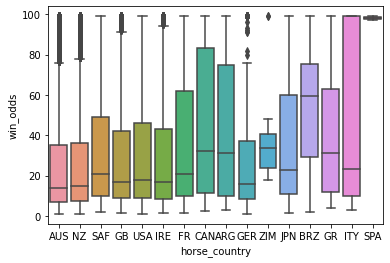

In [6]:
sns.boxplot(x="horse_country",y="win_odds",data=runs_df)
plt.show()

#### Win Odds and Horse Type

Next, we looked at horse type, which based on previous labs tended to be an important feature. Geldings, Browns, and Greys had smaller distributions of win odds. Geldings had the best odds on average. Ris, Colts, and Fillys would be less sure bets based on the distribution of odds for those types of horses.

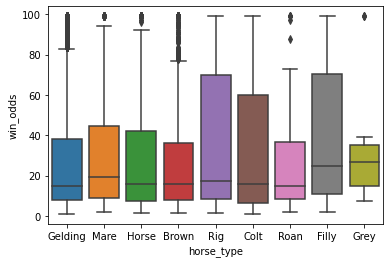

In [7]:
sns.boxplot(x="horse_type",y="win_odds",data=runs_df)
plt.show()

#### Win Odds and Finish Place

Based on previous labs, far and away the most important feature in determining a result was the horse's win odds. The graph below plots that relationship. As can be seen, there is a strong relationship. Horses with better odds were not only more likely to win (based on mean) but had much smaller distributions. Intuitively, this makes sense. Horse odds are set by professionals who have the best information and insight into the chances a horse will win a particular race.

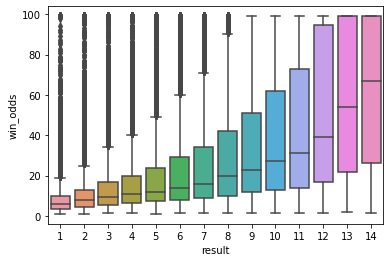

In [12]:
sns.boxplot(x='result', y='win_odds', data=runs_df)
plt.show()

#### Place Odds and Finish Position

Similarly to win odds, we plotted place odds against result. As would be expected, the relationship is very similar to win odds. In fact the range of distribution is smaller. That makes sense since win is determined by a horse finishing in a single position (1) whereas place is the horse finishing in first through third, so it is more forgiving. 

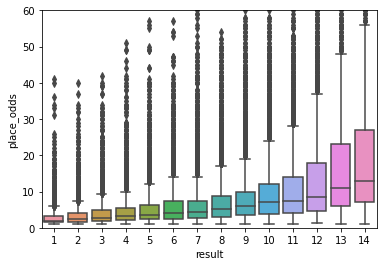

In [13]:
sns.boxplot(x='result', y='place_odds', data=runs_df)
plt.ylim(0,60)
plt.show()

#### Draw and Finish Position

The draw of a horse is random. Which horse begins the race in which stall is not determined by win odds or any other factor. It's a well known fact in racing that the "inside" track is preferred since it reduces the overall distance you have to travel. Therefore it intuitively makes sense that a horse beginning the race inside (draw 1) would have a slightly better chance in the race.

The chart below backs this up, to an extent. It is clear that the higher draw a hhorse has (the further from pole position they begin), the worse result they have on average.

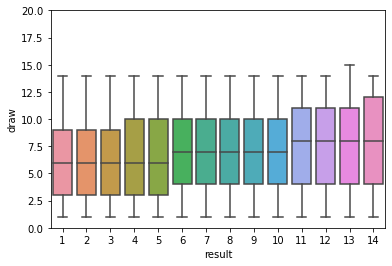

In [24]:
sns.boxplot(x='result', y='draw', data=runs_df)
plt.ylim(0,20)
plt.show()

#### Win Odds vs Result with Confidence Interval

Since it is clear there is a strong relationship between a horse's win or place odds and their result, we took another look at that relationship in another way.

The two plots below show the linear relationship between win odds an result, and place odds and result, with confidence intervals. Note how small he intervals. As the odds for a horse get worse, the interval gets larger, but only slightly. 

<AxesSubplot:xlabel='result', ylabel='win_odds'>

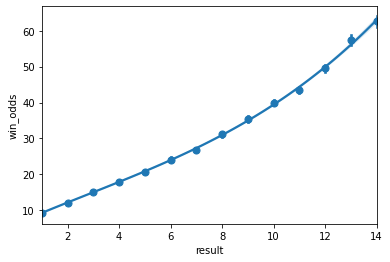

In [16]:
sns.regplot(x="result", y="win_odds", data=runs_df, x_estimator=np.mean, order=3)

#### Place Odds vs Result with Confidence Interval

Refer to the description above.

<AxesSubplot:xlabel='result', ylabel='place_odds'>

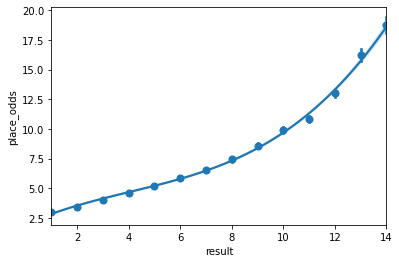

In [17]:
sns.regplot(x="result", y="place_odds", data=runs_df, x_estimator=np.mean, order=3)

#### Draw vs Result with Confidence Interval

Again, we plotted the linear relationship. This time between draw and result. We showed earlier their is a relationship between draw and result, but you could see it was not as strong as the relationship between win or place odds and result.

The confidence intervals for the below plot support the claim that the relationship is not as strong. The confidence intervals are not nearly as tight, meaning their is a wider distribution. So, the draw is an important feature in result, but it is not as much of a "sure thing" as win or place odds.

<AxesSubplot:xlabel='result', ylabel='draw'>

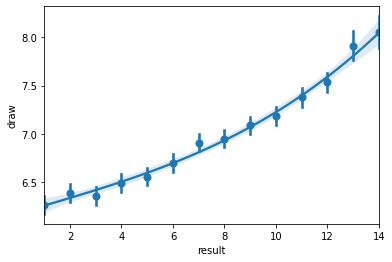

In [22]:
sns.regplot(x="result", y="draw", data=runs_df, x_estimator=np.mean, order=3)

#### Win Odds vs Place Odds, by Result

The last plot we chose to include in this report is a scatterplot showing win odds vs. place odds, categorized by result. The lighter the color, the better result, or finishing position. The darker the color, the worse the result.

It is clear, on the bottom-left of the graph the data points are lighter. In other words, a horse with lower win and place odds tends to finish the race in a better position. 

For this we filtered the data set for place odds of less than 30:1. There are a large number of outliers that make the plot less clear to read. We included the unfiltered plot below, for reference.

<AxesSubplot:xlabel='win_odds', ylabel='place_odds'>

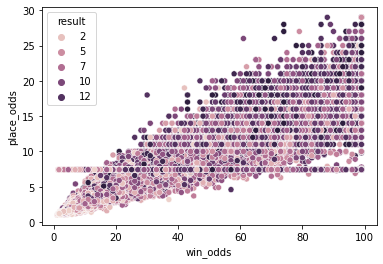

In [45]:
runs_df_lower_odds = runs_df[runs_df['place_odds'] < 30] 
sns.scatterplot(x='win_odds', y='place_odds', hue='result', data=runs_df_lower_odds)

#### Same plot but unfiltered for outliers

<AxesSubplot:xlabel='win_odds', ylabel='place_odds'>

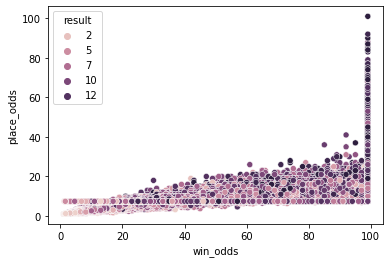

In [46]:
sns.scatterplot(x='win_odds', y='place_odds', hue='result', data=runs_df)

## Section 4: Modeling and Evaluation 1

Train and adjust parameters

...

In [27]:
X_train,X_test,Y_train,Y_test = train_test_split(runs_data,runs_target,test_size=0.20,random_state=0)

In [34]:
from sklearn.cluster import KMeans

kmeans = KMeans(
    init='k-means++', # initialization
    n_clusters=10,    # number of clusters
    n_init=3,         # number of different times to run k-means
    n_jobs=-1)

kmeans.fit(X_train)

yhat= kmeans.predict(X_test)
acc = mt.accuracy_score(Y_test,yhat)
prec = mt.precision_score(Y_test,yhat,average='micro')
auc = roc_auc_score(Y_test,yhat)
conf = mt.confusion_matrix(Y_test,yhat)

print('Precision is: %.3f'%(prec), ' AUC: %.3f'%auc)

Precision is: 0.118  AUC: 0.547


## Section 5: Modeling and Evaluation 2

Evaluate and Compare

...

## Section 6: Modeling and Evaluation 3

Visualize Results

...

## Section 7: Modeling and Evaluation 4

Summarize the Ramifications

...

## Section 8: Deployment

Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling? How useful is your model for interested parties (i.e., the companies or organizations that might want to use it)? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?

...

## Section 9: Exceptional Work

You have free reign to provide additional analyses or combine analyses.

...